In [401]:
import sys, os
sys.path.append('../')

# Use Theano version of lensing gradient
os.environ["DIFF"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from units import *
from tqdm import *
import pymc3 as pm
from lensing_sim import LensingSim
import corner
import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [394]:
# Grid size
nx, ny = 25, 25

In [395]:
1e40*1e-17*erg/Centimeter**2/Sec/Angstrom

0.03155971088898969

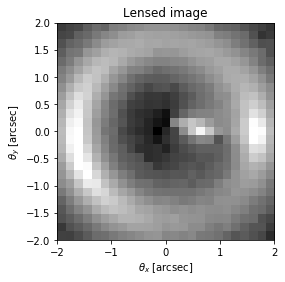

In [396]:
# Host and substructure parameters
hst_param_dict = {'profile':'sis', 'theta_x':0.1, 'theta_y':-0.15, 'theta_E':1.14}
sub1_param_dict = {'profile':'sis', 'theta_x':1., 'theta_y':0.15, 'theta_E':0.3}
sub2_param_dict = {'profile':'sis', 'theta_x':1., 'theta_y':0.15, 'theta_E':0.3}

# Source parameters
src_param_dict = {'profile':'sersic', 'I_gal':1e40*1e-17*erg/Centimeter**2/Sec/Angstrom,'theta_e_gal':0.5,'n_srsc':4}

# Observational parameters
observation_dict = {'nx':nx, 'ny':ny, 'xlims':[-2, 2], 'ylims':[-2, 2], 'exposure':1e-40*(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2, 'z_s':1.0, 'z_l':0.2}
global_dict = {'z_s':1.0, 'z_l':0.2}

# Generate lensed image
LSI = LensingSim([hst_param_dict,sub1_param_dict, sub2_param_dict], [src_param_dict], global_dict, observation_dict)

i_tot = np.random.poisson((LSI.lensed_image()).numpy())

plt.imshow(np.log10(i_tot), vmax=3.5, cmap = 'gist_gray', extent=LSI.xlims+LSI.ylims)
plt.xlabel("$\\theta_x$ [arcsec]");
plt.ylabel("$\\theta_y$ [arcsec]");
plt.title('Lensed image');

i_tot = torch.from_numpy(i_tot)

In [397]:
i_tot = i_tot.type(torch.FloatTensor)

In [398]:
import corner

In [402]:
from __future__ import absolute_import, division, print_function

import sys
sys.path.append('../pyro/examples/eight_schools')

import argparse
import logging

import pandas as pd
import torch

import data
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.mcmc import MCMC, NUTS

logging.basicConfig(format='%(message)s', level=logging.INFO)
pyro.enable_validation(True)
pyro.set_rng_seed(4)


def model():
    theta_E = pyro.sample('theta_E', dist.Uniform(1.0*torch.ones(1), 1.3*torch.ones(1)))
    theta_x = pyro.sample('theta_x', dist.Normal(0.05*torch.ones(1), 0.15*torch.ones(1)))
    theta_y = pyro.sample('theta_y', dist.Normal(-0.15*torch.ones(1), 1.*torch.ones(1)))
    
    theta_E_sub = pyro.sample('theta_E_sub', dist.Uniform(0.1*torch.ones(1), 0.5*torch.ones(1)))
    theta_x_sub = pyro.sample('theta_x_sub', dist.Uniform(0.8*torch.ones(1), 1.5*torch.ones(1)))
    theta_y_sub = pyro.sample('theta_y_sub', dist.Uniform(0.1*torch.ones(1), 0.5*torch.ones(1)))

    hst_param_dict = {'profile':'sis', 'theta_x':theta_x.type(torch.double), 'theta_y':theta_y.type(torch.double), 'theta_E':theta_E.type(torch.double)}
    sub_param_dict = {'profile':'sis', 'theta_x':theta_x_sub.type(torch.double), 'theta_y':theta_y_sub.type(torch.double), 'theta_E':theta_E_sub.type(torch.double)}

    LSI.lenses_list = [hst_param_dict, sub_param_dict]

    mu = LSI.lensed_image()
    obs = (pyro.sample("obs", dist.Poisson(rate = mu )) )
    return obs

def conditioned_model(model, data):
    return poutine.condition(model, data={"obs": data})()


def main(jit=False, num_samples=2000, num_chains=1, warmup_steps=2000, step_size=0.1):
    nuts_kernel = NUTS(conditioned_model, jit_compile=jit,step_size=step_size, adapt_step_size=True)
    posterior = MCMC(nuts_kernel,
                     num_samples=num_samples,
                     warmup_steps=warmup_steps,
                     num_chains=num_chains
                    ).run(model, i_tot)
    marginal = posterior.marginal(sites=["theta_E","theta_x","theta_y","theta_E_sub","theta_x_sub","theta_y_sub"])
    marginal = torch.cat(list(marginal.support(flatten=True).values()), dim=-1).cpu().numpy()
    params = ['theta_E',"theta_x","theta_y","theta_E_sub","theta_x_sub","theta_y_sub"]
    df = pd.DataFrame(marginal, columns=params).transpose()
    df_summary = df.apply(pd.Series.describe, axis=1)[["mean", "std", "25%", "50%", "75%"]]
    logging.info(df_summary)
    corner.corner(marginal, labels=params)

                 mean       std       25%       50%       75%
theta_E      1.239550  0.000209  1.239418  1.239525  1.239688
theta_x      0.141784  0.000960  0.141144  0.141651  0.142346
theta_y     -0.129037  0.000439 -0.129293 -0.129019 -0.128726
theta_E_sub  0.499965  0.000032  0.499952  0.499972  0.499988
theta_x_sub  0.999077  0.001302  0.998914  0.999603  0.999852
theta_y_sub  0.166464  0.000356  0.166288  0.166450  0.166582
Too few points to create valid contours


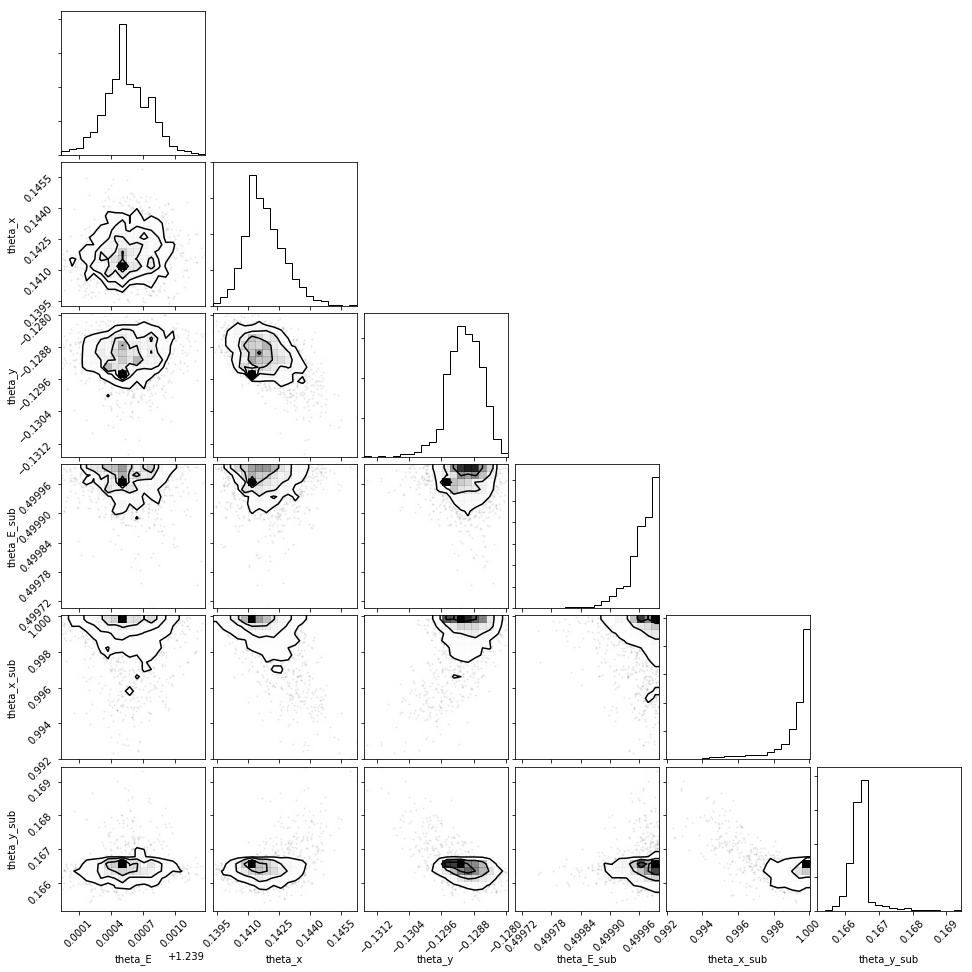

In [403]:
main();

In [243]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
import pyro.distributions as dist
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


In [294]:
from pyro.util import optional


In [383]:
def model():
    z = pyro.sample("z", dist.Categorical(torch.ones(5)))
#     print('model z = {}'.format(z))

def guide():
    z = pyro.sample("z", dist.Categorical(torch.ones(5)))
#     print('guide z = {}'.format(z))

elbo = TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(model, config_enumerate(guide, "sequential"));


In [391]:
def model():
    
#     n_exp = pyro.sample('n_exp', dist.Uniform(0.0*torch.ones(1), 10*torch.ones(1)))
    z = pyro.sample('z', dist.Categorical(torch.ones(5)))#.type(torch.int)
#     n_subs = np.random.poisson(n_exp.numpy())
    
#     hst_param_dict = {'profile':'sis', 'theta_x':0.1, 'theta_y':-0.15, 'theta_E':1.14}
    
#     lenses_list = [hst_param_dict]
    
# #     for i_sub in range(n_subs):
# #         theta_x_sub = pyro.param('theta_x_sub_{}'.format(i_sub), dist.Uniform(0.8*torch.ones(1), 1.2*torch.ones(1)))
# #         theta_y_sub = pyro.param('theta_y_sub_{}'.format(i_sub), dist.Uniform(0.1*torch.ones(1), 0.2*torch.ones(1)))
# #         lenses_list.append({'profile':'sis', 'theta_x':theta_x_sub.type(torch.double), 'theta_y':theta_y_sub.type(torch.double), 'theta_E':0.3})
#     LSI.lenses_list = lenses_list

#     mu = LSI.lensed_image()
#     with pyro.iarange("data_dim1", len(mu)):
#         with pyro.iarange("data_dim2", len(mu[0])):
#             pyro.sample("obs", dist.Poisson(rate = mu), obs=i_tot)

def guide():
    z = pyro.sample('z', dist.Categorical(torch.ones(5)))#.type(torch.int)

    
    from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
elbo = TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(model, config_enumerate(guide, "parallel"));


In [392]:
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
elbo = TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(model, config_enumerate(guide, "parallel"));


In [388]:
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
guide = AutoDiagonalNormal(model)
# guide = AutoMultivariateNormal(model)

In [389]:
num_iterations = 10000
optim = Adam({"lr": 0.001})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=2000)

NotImplementedError: Cannot transform _IntegerInterval constraints
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites:

In [314]:
def train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step()
        if j % 200 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / np.sum(np.shape(i_tot))))
#             print("[iteration %04d]"  % (j + 1))

train()

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
svi_diagnorm_posterior = svi.run()

In [212]:
def summary(traces, sites):
    marginal = EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats


In [225]:
sites = ["n_exp", "n_subs", "theta_x_sub_1","theta_x_sub_2","theta_x_sub_3","theta_x_sub_4"]

for site, values in summary(svi_diagnorm_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")


Site: n_exp
       mean       std        5%       25%       50%       75%       95%
0  4.920667  2.899096  0.550858  2.350831  4.829262  7.508105  9.415772 

Site: n_subs
   mean  std   5%  25%  50%  75%  95%
0   5.0  0.0  5.0  5.0  5.0  5.0  5.0 

Site: theta_x_sub_1
       mean  std        5%       25%       50%       75%       95%
0  0.884464  0.0  0.884464  0.884464  0.884464  0.884464  0.884464 

Site: theta_x_sub_2
       mean  std        5%       25%       50%       75%       95%
0  1.771889  0.0  1.771889  1.771889  1.771889  1.771889  1.771889 

Site: theta_x_sub_3
       mean  std        5%       25%       50%       75%       95%
0  1.826294  0.0  1.826295  1.826295  1.826295  1.826295  1.826295 

Site: theta_x_sub_4
       mean  std        5%       25%       50%       75%       95%
0 -1.200592  0.0 -1.200593 -1.200593 -1.200593 -1.200593 -1.200593 



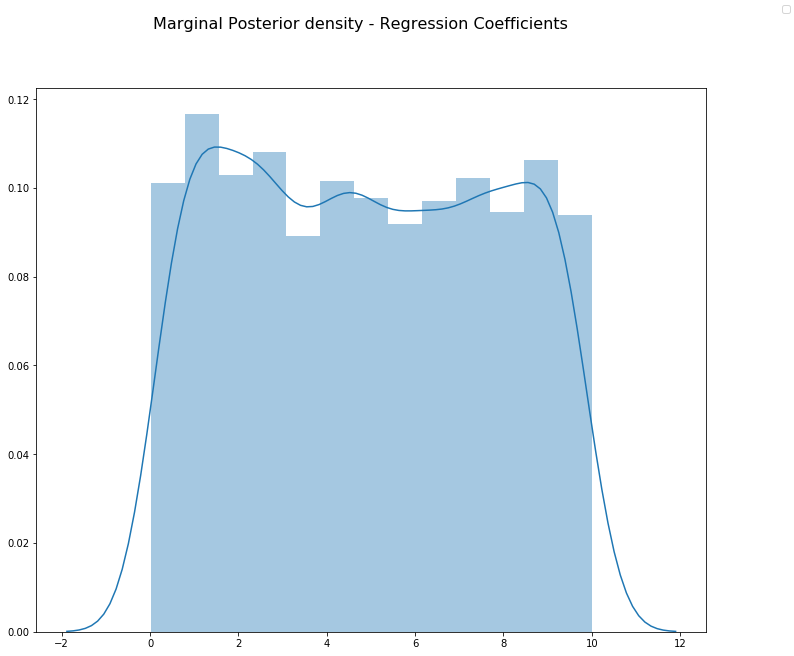

In [218]:
svi_diagnorm_empirical = EmpiricalMarginal(svi_diagnorm_posterior, sites=sites) \
                         ._get_samples_and_weights()[0] \
                         .detach().cpu().numpy()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
sns.distplot(svi_diagnorm_empirical[:,0,0], label="SVI (DiagNormal)")

ax.set_title(sites[0])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
